# Imports


In [ ]:
!pip install keras-nlp
!pip install bpemb
!pip install tensorflow -U
!pip install keras -U

In [51]:
import os
import re
import numpy as np
import matplotlib.pyplot as plt
from bpemb import BPEmb
import tensorflow as tf
import keras
import keras_nlp
from keras import layers
from keras.applications import efficientnet, InceptionResNetV2
from keras.layers import TextVectorization
from typing import DefaultDict

# Download the Dataset

In [ ]:
!wget -q https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_Dataset.zip
!wget -q https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_text.zip
!unzip -qq Flickr8k_Dataset.zip
!unzip -qq Flickr8k_text.zip
!rm Flickr8k_Dataset.zip Flickr8k_text.zip

In [52]:
IMAGES_PATH = 'Flicker8k_Dataset'
CAPTIONS_PATH = 'Flickr8k.token.txt'
IMAGE_SIZE = (229, 229)
VOCAB_SIZE = 10000
SEQ_LENGTH = 25
EMBED_DIM = 512
FF_DIM = 512
BATCH_SIZE = 64
EPOCHS = 80
AUTOTUNE = tf.data.AUTOTUNE

# Preparing the Dataset

In [53]:
def load_captions_data(filename):
  """Loads captions (text) data and maps them to corresponding images.

  Args:
    filename: Path to the text file containing caption data.

  Returns:
    caption_mapping: Dictionary with keys as image ids and values as a list of
      captions for the image.
    text_data: List containing all captions from the file.
  """

  with open(filename) as caption_file:
    caption_data = caption_file.readlines()
    caption_mapping = DefaultDict(list)
    text_data = []
    images_to_skip = set()

    for line in caption_data:
      line = line.rstrip('\n')
      image_name, caption = line.split('\t')

      image_name = image_name.split("#")[0]
      image_name = os.path.join(IMAGES_PATH, image_name.strip())

      # Remove caption that are either too short or too ling
      tokens = caption.strip().split()
      if len(tokens) < 5 or len(tokens) > SEQ_LENGTH:
        images_to_skip.add(image_name)
        continue

      if image_name not in images_to_skip and image_name.endswith("jpg"):
        caption = '<start> ' + caption.strip() + ' <end>'
        caption_mapping[image_name].append(caption)
        text_data.append(caption)

  for image_name in images_to_skip:
    if image_name in caption_mapping:
      del caption_mapping[image_name]

  return caption_mapping, text_data


In [54]:
def train_val_split(caption_data, train_size=0.8, shuffle=True):
  """Split the captioning dataset into train and validation sets.

    Args:
        caption_data (dict): Dictionary containing the mapped caption data
        train_size (float): Fraction of all the full dataset to use as training data
        shuffle (bool): Whether to shuffle the dataset before splitting

    Returns:
        Traning and validation datasets as two separated dicts
  """

  all_images = list(caption_data.keys())

  if shuffle:
    np.random.shuffle(all_images)

  # Split into train and validation set
  train_size = int(len(caption_data) * train_size)

  training_data = {
      img_name: caption_data[img_name] for img_name in all_images[:train_size]
  }

  validation_data = {
      img_name: caption_data[img_name] for img_name in all_images[train_size:]
  }

  return training_data, validation_data

In [55]:
# Load the Dataset
captions_mapping, text_data = load_captions_data(CAPTIONS_PATH)
train_data, valid_data = train_val_split(captions_mapping)
print("Number of Traning Samples: ", len(train_data))
print("Number of Validation Samples: ", len(valid_data))

Number of Traning Samples:  6114
Number of Validation Samples:  1529


# Vectorizing the text data

We'll use the TextVectorization layer to vectorize the text data, that is to say, to turn the original strings into integer sequences where each integer represents the index of a word in a vocabulary. We will use a custom string standardization scheme (strip punctuation characters except < and >) and the default splitting scheme (split on whitespace).

## TextVectorization Word level

In [56]:
def custom_standardization(input_string):
  lowercase = tf.strings.lower(input_string)
  return tf.strings.regex_replace(lowercase, "[%s]" % re.escape(strip_chars), "")

strip_chars = "!\"#$%&'()*+,-./:;<=>?@[\]^_`{|}~"
strip_chars = strip_chars.replace("<", "")
strip_chars = strip_chars.replace(">", "")

vectorization = TextVectorization(
    max_tokens=VOCAB_SIZE,
    output_mode="int",
    output_sequence_length=SEQ_LENGTH,
    standardize=custom_standardization,
)

vectorization.adapt(text_data)

# Data augmentation for image data
image_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.2),
        layers.RandomContrast(0.3),
    ]
)



## Byte Pair Encoding

In [8]:
# load English BPEmb model with default vocabulary size (10k)
bpemb_en = BPEmb(lang="en")

In [9]:
bpemb_vocab_size, bpemb_embed_size = bpemb_en.vectors.shape
print("Vocabulary size:", bpemb_vocab_size)
print("Embedding size:", bpemb_embed_size)

Vocabulary size: 10000
Embedding size: 100


In [10]:
# Embedding for the word "car".
bpemb_en.vectors[bpemb_en.words.index('car')]
# don't need the embeddings since we're going to use our own embedding layer.
# What we're interested in are the subword tokens and their respective ids.
# The ids will be used as indexes into our embedding layer.

array([-0.305548, -0.325598, -0.134716, -0.078735, -0.660545,  0.076211,
       -0.735487,  0.124533, -0.294402,  0.459688,  0.030137,  0.174041,
       -0.224223,  0.486189, -0.504649, -0.459699,  0.315747,  0.477885,
        0.091398,  0.427867,  0.016524, -0.076833, -0.899727,  0.493158,
       -0.022309, -0.422785, -0.154148,  0.204981,  0.379834,  0.070588,
        0.196073, -0.368222,  0.473406,  0.007409,  0.004303, -0.007823,
       -0.19103 , -0.202509,  0.109878, -0.224521, -0.35741 , -0.611633,
        0.329958, -0.212956, -0.497499, -0.393839, -0.130101, -0.216903,
       -0.105595, -0.076007, -0.483942, -0.139704, -0.161647,  0.136985,
        0.415363, -0.360143,  0.038601, -0.078804, -0.030421,  0.324129,
        0.223378, -0.523636, -0.048317, -0.032248, -0.117367,  0.470519,
        0.225816, -0.222065, -0.225007, -0.165904, -0.334389, -0.20157 ,
        0.572352, -0.268794,  0.301929, -0.005563,  0.387491,  0.261031,
       -0.11613 ,  0.074982, -0.008433,  0.259987, 

In [11]:
sample_sentence = "Where can I find a pizzeria?"
tokens = bpemb_en.encode(sample_sentence)
print(tokens)

['▁where', '▁can', '▁i', '▁find', '▁a', '▁p', 'iz', 'zer', 'ia', '?']


In [12]:
token_seq = np.array(bpemb_en.encode_ids("Where can I find a pizzeria?"))
print(token_seq)

[ 571  280  386 1934    4   24  248 4339  177 9967]


In [13]:
np.array(list(train_data.values())).shape # The shape is the main issus with bepMB. Therefore cannot use it for this project

(6114, 5)

# Building a `tf.data.Dataset` pipeline for training

We will generate pairs of images and corresponding captions using a tf.data.Dataset object. The pipeline consists of two steps:

Read the image from the disk
Tokenize all the five captions corresponding to the image

In [58]:
def decode_and_resize(img_path):
  img = tf.io.read_file(img_path) # result is a tensor of type tf.string containing the raw bytes of the image file.
  img = tf.image.decode_jpeg(img, channels=3) # decode the raw bytes into a tensor representing the image
  img = tf.image.resize(img, IMAGE_SIZE)
  img = tf.image.convert_image_dtype(img, tf.float32)
  return img


def process_input(img_path, captions):
  return decode_and_resize(img_path), vectorization(captions)


def make_dataset(images, captions):
  dataset = tf.data.Dataset.from_tensor_slices((images, captions))
  dataset = dataset.shuffle(BATCH_SIZE * 8)
  dataset = dataset.map(process_input, num_parallel_calls=AUTOTUNE)
  dataset = dataset.batch(BATCH_SIZE).prefetch(AUTOTUNE)

  return dataset

# Pass the list of images path and the list of corrosponding captions
train_dataset = make_dataset(list(train_data.keys()), list(train_data.values()))
valid_dataset = make_dataset(list(valid_data.keys()), list(valid_data.values()))


# Building the model

Our image captioning architecture consists of three models:

1. A CNN: used to extract the image features
2. A TransformerEncoder: The extracted image features are then passed to a Transformer based encoder that generates a new representation of the inputs
3. A TransformerDecoder: This model takes the encoder output and the text data (sequences) as inputs and tries to learn to generate the caption.

## Get CNN model

In [60]:
def get_EfficientNetB0():
    return efficientnet.EfficientNetB0(
      input_shape=(*IMAGE_SIZE, 3),
      include_top=False,
      weights="imagenet",
  )

def get_InceptionResNetV2():
    return InceptionResNetV2(
      input_shape=(*IMAGE_SIZE, 3),
      include_top=False,
      weights="imagenet",
    )

def get_cnn_model(model_name='EfficientNetB0'):
  if  model_name == "EfficientNetB0":
    base_model = get_EfficientNetB0()
  elif model_name == "InceptionResNetV2":
    base_model = get_InceptionResNetV2()

  # Frease our feature extractor
  base_model.trainable = False
  base_model_out = base_model.output
  # (None, 8, 8, 1280) ->(None, 8*8, 1280)(None,         64,       1280)
  # Intrepretation of the shape  ->      (Batch_size, seq_len, emded_dim) <- for understanding only not actually sequence length or embed_dim
  # This is the input require by Encoder
  base_model_out = layers.Reshape((-1, base_model_out.shape[-1]))(base_model_out)
  cnn_model = keras.models.Model(base_model.input, base_model_out)

  return cnn_model

## TransformerEncoderBlock

In [80]:
class TransformerEncoderBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, **kwargs):
        super(TransformerEncoderBlock, self).__init__(**kwargs)

        self.embed_dim = embed_dim
        self.num_heads = num_heads

        self.mhsa1 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim, dropout=0.0
        )

        self.layernorm1 = layers.LayerNormalization()
        self.layernorm2 = layers.LayerNormalization()
        self.layernorm3 = layers.LayerNormalization()

        self.dropout1 = layers.Dropout(0.2)

        self.dense1 = layers.Dense(embed_dim, activation="relu")

        self.point_wise_fc = keras.Sequential(
            [layers.Dense(embed_dim, activation="relu"), layers.Dense(embed_dim)]
        )

    def call(self, inputs, training, mask=None):
        inputs = self.layernorm1(inputs)
        inputs = self.dense1(inputs)

        inputs = self.layernorm2(inputs)
        mhsa1_output = self.mhsa1(
            key=inputs,
            query=inputs,
            value=inputs,
            training=training,
            attention_mask=None,
        )

        skip_output = mhsa1_output + inputs
        layer_norm_output = self.layernorm3(skip_output)
        encoder_output = self.point_wise_fc(layer_norm_output)
        encoder_output = self.dropout1(encoder_output, training=training)

        return encoder_output

### Test Encoder run

In [63]:
model = get_cnn_model()
encoder = TransformerEncoderBlock(EMBED_DIM, 4)

In [64]:
image = decode_and_resize("Flicker8k_Dataset/3532782283_341f0381a3.jpg")
# print(image)

In [65]:
# valid_data

In [66]:
image.shape

TensorShape([229, 229, 3])

In [67]:
image_u = tf.expand_dims(input=image, axis=0)
image_u.shape

TensorShape([1, 229, 229, 3])

In [68]:
image_feature = model(image_u)

In [69]:
image_feature.shape

TensorShape([1, 64, 1280])

In [70]:
encoder_output_t = encoder(image_feature, training=True)

In [71]:
encoder_output_t

<tf.Tensor: shape=(1, 64, 512), dtype=float32, numpy=
array([[[ 0.28915757,  1.8607651 , -0.6066678 , ..., -0.498448  ,
          1.475647  , -0.9487376 ],
        [-0.21697927,  1.8871148 , -0.949509  , ..., -0.73811   ,
          1.8307567 , -0.73266035],
        [ 0.        ,  0.        , -1.286316  , ...,  0.        ,
          1.7616799 , -0.13077153],
        ...,
        [-0.27954295,  0.78809315,  0.13733894, ...,  0.96773195,
          2.044457  , -1.819178  ],
        [-0.37189937,  0.72338593,  0.35377264, ...,  0.978581  ,
          2.3933382 , -1.8844421 ],
        [ 0.        ,  0.3860935 ,  0.5793153 , ...,  0.66040826,
          2.0329921 ,  0.        ]]], dtype=float32)>

## PositionalEmbedding

In [72]:
class PositionalEmbedding(layers.Layer):
    def __init__(self, sequence_length, vocab_size, embed_dim, **kwargs):
        super(PositionalEmbedding, self).__init__(**kwargs)

        self.sequence_length = sequence_length
        self.vocab_size = vocab_size
        self.embed_dim = embed_dim

        self.token_embeddings = layers.Embedding(vocab_size, embed_dim)
        self.position_embeddings = keras_nlp.layers.PositionEmbedding(sequence_length)

        self.embed_scale = tf.math.sqrt(tf.cast(embed_dim, tf.float32))


    def call(self, inputs):
        embed_tokens = self.token_embeddings(inputs)
        embed_tokens = embed_tokens * self.embed_scale
        embed_postion = self.position_embeddings(embed_tokens)
        return embed_tokens + embed_postion

    def compute_mask(self, inputs, mask=None):
        return tf.math.not_equal(inputs, 0)

### Test PositionalEmbedding run

In [73]:
text = captions_mapping['Flicker8k_Dataset/365274901_576b0f8241.jpg']
pe = PositionalEmbedding(SEQ_LENGTH, VOCAB_SIZE, EMBED_DIM)
pe(vectorization(text))

<tf.Tensor: shape=(5, 25, 512), dtype=float32, numpy=
array([[[ 0.42054456,  0.8099443 , -0.1644516 , ...,  0.67269236,
          0.83445215, -1.066571  ],
        [ 0.4283171 , -0.8660782 ,  0.16401856, ..., -0.5666268 ,
         -0.53920287, -0.8586431 ],
        [-0.90477705, -0.6071611 ,  0.08963556, ...,  0.7405356 ,
          1.0936849 , -0.49542826],
        ...,
        [ 0.29584625,  0.33135262, -0.9208017 , ..., -0.26635572,
         -0.41250062,  0.9454121 ],
        [ 0.20877965,  0.4116722 , -0.96070856, ..., -0.36983764,
         -0.4566196 ,  0.9781796 ],
        [ 0.26359677,  0.31611365, -0.9813214 , ..., -0.1919524 ,
         -0.49725464,  0.9688898 ]],

       [[ 0.42054456,  0.8099443 , -0.1644516 , ...,  0.67269236,
          0.83445215, -1.066571  ],
        [ 0.19333139,  0.3649212 ,  0.12248966, ..., -0.8387112 ,
          0.9903755 ,  0.08658727],
        [-0.261164  ,  0.65399504,  0.14032507, ..., -0.31747466,
         -0.85291183,  1.1296711 ],
        ...,


## TransformerDecoderBlock

In [74]:
class TransformerDecoderBlock(layers.Layer):
    def __init__(self, embed_dim, ff_dim, num_heads, **kwargs):
        super(TransformerDecoderBlock, self).__init__()
        self.embed_dim = embed_dim
        self.ff_dim = ff_dim
        self.num_heads = num_heads

        self.mhsa1 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim, dropout=0.2
        )
        self.mhsa2 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim, dropout=0.2
        )

        self.layernorm1 = layers.LayerNormalization()
        self.layernorm2 = layers.LayerNormalization()
        self.layernorm3 = layers.LayerNormalization()

        self.dropout1 = layers.Dropout(0.5)

        self.embeddings = PositionalEmbedding(
            sequence_length=SEQ_LENGTH, vocab_size=VOCAB_SIZE, embed_dim=EMBED_DIM
        )

        self.point_wise_fc1 = keras.Sequential([
                layers.Dense(ff_dim, activation="relu"),
                layers.Dense(embed_dim),
        ])

        self.dense = layers.Dense(VOCAB_SIZE, activation='softmax')

    def call(self, inputs, training, encoder_outputs, mask=None):
        embed_inputs = self.embeddings(inputs) # (5, 24, 512)
        causal_mask = self.get_causal_attention_mask(embed_inputs) # casual_mask.shape => (batch, target_seq_len, source_seq_len)

        if mask is not None: # mask.shape => (batch, target_seq_len)
            padding_mask = tf.cast(mask[:, :, tf.newaxis], dtype=tf.int32)  # padding_mask.shape => (batch, target_seq_len, 1)
            combined_mask = tf.cast(mask[:, tf.newaxis, :], dtype=tf.int32) # combined_mask.shape => (batch, 1, target_seq_len)
            combined_mask = tf.minimum(combined_mask, causal_mask)          # combined_mask.shape => (batch, target_seq_len, source_seq_len)
        else:
            padding_mask = None
            combined_mask = None


        inputs1 = self.layernorm1(embed_inputs)
        attention_output1 = self.mhsa1(
            key=inputs1,
            query=inputs1,
            value=inputs1,
            attention_mask=combined_mask, # shape -> (B, T, S) => (batch_size, target_sqe_len, source_seq_len)
            training=training,
            # use_causal_mask=True
        )

        inputs2 = self.layernorm2(attention_output1 + embed_inputs)
        attention_output2 = self.mhsa2(
            key=encoder_outputs,
            query=inputs2,
            value=encoder_outputs,
            attention_mask=padding_mask, # shape -> (batch_size, target_sqeuence, 1) => source_seq_len is 1 cause want to apply it to all uniformly
            # as there is no zero or pad token present in encoder input cause the input is the image feature map and always have same lenght
            training=training
        )

        inputs3 = self.layernorm3(attention_output2 + inputs2)
        fc_output1 = self.point_wise_fc1(inputs3)
        output3 = self.dropout1(fc_output1, training=training)

        output4 = self.dense(output3)

        return output4

    def get_causal_attention_mask(self, inputs):
        input_shape = tf.shape(inputs)
        batch_size, sequence_length = input_shape[0], input_shape[1]
        i = tf.range(sequence_length)[:, tf.newaxis]
        j = tf.range(sequence_length)
        mask = tf.cast(i >= j, dtype="int32")
        mask = tf.reshape(mask, (1, input_shape[1], input_shape[1]))
        mult = tf.concat(
            [
                tf.expand_dims(batch_size, -1),
                tf.constant([1, 1], dtype=tf.int32),
            ],
            axis=0,
        )
        return tf.tile(mask, mult)


### Test TransformerDecoderBlock run

In [75]:
ls

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


CrowdFlowerAnnotations.txt  Flickr8k.token.txt         __MACOSX/
ExpertAnnotations.txt       Flickr_8k.devImages.txt    readme.txt
Flicker8k_Dataset/          Flickr_8k.testImages.txt
Flickr8k.lemma.token.txt    Flickr_8k.trainImages.txt


In [76]:
keras.__version__

'3.4.1'

In [77]:
decoder = TransformerDecoderBlock(EMBED_DIM, FF_DIM, 4)
decoder_input = vectorization(text[:3])[:, :-1]
mask = tf.math.not_equal(decoder_input, 0)
decoder(decoder_input, training=True, encoder_outputs=encoder_output_t, mask=mask)

<tf.Tensor: shape=(3, 24, 10000), dtype=float32, numpy=
array([[[2.15435473e-04, 7.10056192e-05, 1.02569720e-04, ...,
         1.22121652e-04, 7.78714020e-05, 1.41110926e-04],
        [1.16896423e-04, 9.97841271e-05, 1.05685038e-04, ...,
         1.03329694e-04, 9.24466585e-05, 1.06434549e-04],
        [1.77873313e-04, 1.31728113e-04, 1.34336879e-04, ...,
         1.59683725e-04, 9.75987059e-05, 2.05751479e-04],
        ...,
        [1.15230228e-04, 6.65765183e-05, 1.30292799e-04, ...,
         1.22112338e-04, 1.04940045e-04, 9.44209896e-05],
        [1.50044478e-04, 1.20416073e-04, 1.33529684e-04, ...,
         9.88499742e-05, 9.20770253e-05, 1.48905587e-04],
        [9.47207736e-05, 1.13655828e-04, 1.15451512e-04, ...,
         9.28607260e-05, 1.17147240e-04, 1.48328007e-04]],

       [[1.52818975e-04, 1.03208673e-04, 1.16867741e-04, ...,
         1.14207345e-04, 9.46233267e-05, 1.28152198e-04],
        [1.21071324e-04, 9.20116945e-05, 1.24602637e-04, ...,
         1.08900058e-04, 6.

## ImageCaptioningModel

In [81]:
class ImageCaptioningModel(keras.Model):
    def __init__(self, encoder, decoder, cnn_model, num_caption_per_image=5, data_aug=None):
        super(ImageCaptioningModel, self).__init__()

        self.encoder = encoder
        self.decoder = decoder
        self.cnn_model = cnn_model
        self.num_caption_per_image = num_caption_per_image
        self.data_aug = data_aug
        self.loss_tracker = keras.metrics.Mean(name="loss")
        self.accuracy_tracker = keras.metrics.Mean(name="accuracy")


    def calculate_loss(self, y_true, y_pred, mask):
        loss = self.loss(y_true, y_pred)
        mask = tf.cast(mask, dtype=loss.dtype)
        loss *= mask
        return tf.reduce_sum(loss) / tf.reduce_sum(mask)

    def calculate_accuracy(self, y_true, y_pred, mask):
        accuracy = tf.equal(y_true, tf.argmax(y_pred, axis=2)) # y_pred.shape => (batch_size, seq_len, vocab_size)
        accuracy = tf.logical_and(mask, accuracy)
        accuracy = tf.cast(accuracy, dtype=tf.float32)
        mask = tf.cast(mask, dtype=tf.float32)
        return tf.reduce_sum(accuracy) / tf.reduce_sum(mask)

    def _calculate_loss_and_accuracy(self, img_embed, batch_seq, training):
        encoder_output = self.encoder(img_embed, training=training)
        decoder_input_seq = batch_seq[:,:-1]
        decoder_output_seq = batch_seq[:,1:]
        mask = tf.not_equal(decoder_output_seq, 0)
        decoder_output = self.decoder(decoder_input_seq, training=training, encoder_outputs=encoder_output, mask=mask)

        loss = self.calculate_loss(decoder_output_seq, decoder_output, mask)
        accuracy = self.calculate_accuracy(decoder_output_seq, decoder_output, mask)

        return loss, accuracy

    def train_step(self, batch_data): # batch_data -> tf.data.Dataset
        batch_image, batch_seq = batch_data
        batch_loss = 0
        batch_accuracy = 0

        if self.data_aug:
            batch_image = self.data_aug(batch_image)

        img_embed = self.cnn_model(batch_image)

        for i in range(self.num_caption_per_image):
            with tf.GradientTape() as tape:
                loss, accuracy = self._calculate_loss_and_accuracy(
                    img_embed,
                    batch_seq[:, i, :], # Batch_seq-> (batch_size, no_of_caption, seq_len)
                    training=True
                )

                batch_loss += loss
                batch_accuracy += accuracy

            train_var = (
                self.encoder.trainable_variables
                + self.decoder.trainable_variables
            )
            gradients = tape.gradient(loss, train_var)
            self.optimizer.apply_gradients(zip(gradients, train_var))

        batch_accuracy /= float(self.num_caption_per_image)
        self.loss_tracker.update_state(batch_loss)
        self.accuracy_tracker.update_state(batch_accuracy)

        return {"loss": self.loss_tracker.result(), "accuracy": self.accuracy_tracker.result()}

    def test_step(self, batch_data):
        batch_image, batch_seq = batch_data
        img_embed = self.cnn_model(batch_image)

        batch_loss = 0
        batch_accuracy = 0
        for i in range(self.num_caption_per_image):
            loss, accuracy = self._calculate_loss_and_accuracy(
                img_embed,
                batch_seq[:, i, :], # Batch_seq-> (batch_size, no_of_caption, seq_len)
                training=False
            )

            batch_loss += loss
            batch_accuracy += accuracy

        batch_accuracy /= float(self.num_caption_per_image) # Average across all captions
        self.loss_tracker.update_state(batch_loss)
        self.accuracy_tracker.update_state(batch_accuracy)

        return {"loss": self.loss_tracker.result(), "accuracy": self.accuracy_tracker.result()}

    @property
    def metrics(self):
        # We need to list our metrics here so the `reset_states()` can be
        # called automatically.
        return [self.loss_tracker, self.accuracy_tracker]







In [82]:
cnn_model = get_cnn_model()
encoder = TransformerEncoderBlock(EMBED_DIM, num_heads=1)
decoder = TransformerDecoderBlock(EMBED_DIM, FF_DIM, num_heads=4)
image_captioning_model = ImageCaptioningModel(encoder, decoder, cnn_model, data_aug=image_augmentation)

# Model training

In [83]:
cross_entropy = keras.losses.SparseCategoricalCrossentropy(
    from_logits=False,
#     reduction=None
)

early_stopping = keras.callbacks.EarlyStopping(
    patience=3,
    restore_best_weights=True
)
filepath = 'image_captioning_model_1.keras'
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath,
    monitor='val_loss',
    verbose=1,
    save_best_only=True,
    save_weights_only=False,
    mode='auto',
    save_freq='epoch',
    initial_value_threshold=None
)

class LRSchedule(keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, post_warmup_learning_rate, warmup_steps):
        super().__init__()
        self.post_warmup_learning_rate = post_warmup_learning_rate
        self.warmup_steps = warmup_steps

    def __call__(self, step):
        global_step = tf.cast(step, tf.float32)
        warmup_steps = tf.cast(self.warmup_steps, tf.float32)
        warmup_progress = global_step / warmup_steps
        warmup_learning_rate = self.post_warmup_learning_rate * warmup_progress
        return tf.cond(
            global_step < warmup_steps,
            lambda: warmup_learning_rate,
            lambda: self.post_warmup_learning_rate,
        )

num_train_steps = len(train_dataset) * EPOCHS
num_warmup_steps = num_train_steps // 15
lr_schedule = LRSchedule(post_warmup_learning_rate=1e-4, warmup_steps=num_warmup_steps)

image_captioning_model.compile(optimizer=keras.optimizers.Adam(lr_schedule), loss=cross_entropy)

history = image_captioning_model.fit(
    train_dataset,
    epochs=EPOCHS,
    validation_data=valid_dataset,
    callbacks=[early_stopping],
)



Epoch 1/80
96/96 ━━━━━━━━━━━━━━━━━━━━ 128s 943ms/step - accuracy: 0.0741 - loss: 28.1709 - val_accuracy: 0.2996 - val_loss: 10.2836
Epoch 2/80
96/96 ━━━━━━━━━━━━━━━━━━━━ 86s 901ms/step - accuracy: 0.2960 - loss: 10.1663 - val_accuracy: 0.3417 - val_loss: 9.0032
Epoch 3/80
96/96 ━━━━━━━━━━━━━━━━━━━━ 86s 899ms/step - accuracy: 0.3356 - loss: 8.9580 - val_accuracy: 0.3645 - val_loss: 8.3590
Epoch 4/80
96/96 ━━━━━━━━━━━━━━━━━━━━ 86s 899ms/step - accuracy: 0.3607 - loss: 8.2852 - val_accuracy: 0.3774 - val_loss: 8.0078
Epoch 5/80
96/96 ━━━━━━━━━━━━━━━━━━━━ 87s 903ms/step - accuracy: 0.3766 - loss: 7.8283 - val_accuracy: 0.3897 - val_loss: 7.7575
Epoch 6/80
96/96 ━━━━━━━━━━━━━━━━━━━━ 87s 901ms/step - accuracy: 0.3898 - loss: 7.4908 - val_accuracy: 0.3954 - val_loss: 7.6238
Epoch 7/80
96/96 ━━━━━━━━━━━━━━━━━━━━ 86s 898ms/step - accuracy: 0.4011 - loss: 7.1979 - val_accuracy: 0.3992 - val_loss: 7.6068
Epoch 8/80
96/96 ━━━━━━━━━━━━━━━━━━━━ 86s 898ms/step - accuracy: 0.4107 - loss: 6.9425 - val_

# Infrence


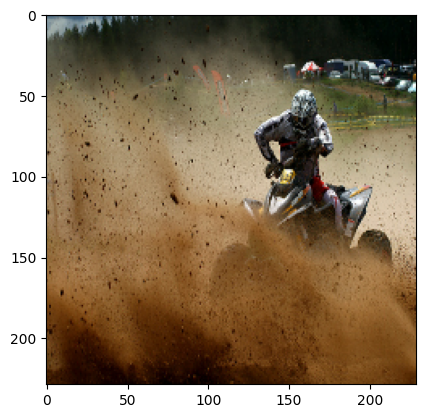

Predicted Caption:  a man is riding a dirt bike on a dirt track


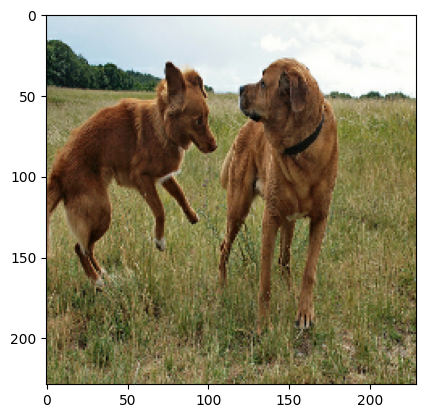

Predicted Caption:  a brown dog is running through a field of grass


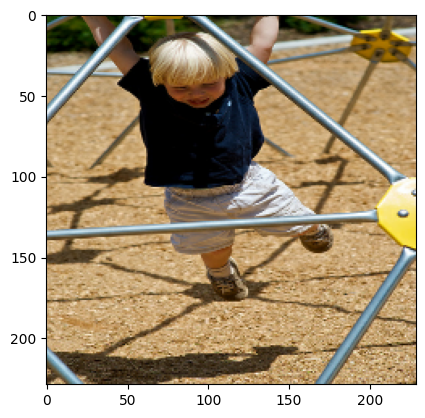

Predicted Caption:  a young boy in a blue shirt is jumping over a fence


In [93]:
# This code snippet is a Python script that generates captions for images using an image captioning model. Here is a breakdown of what the code is doing:
vocab = vectorization.get_vocabulary()
index_lookup = dict(zip(range(len(vocab)), vocab))
max_decoded_sentence_len = SEQ_LENGTH - 1
valid_images = list(valid_data.keys())

def generate_caption():
    sample_img = np.random.choice(valid_images)

    sample_img = decode_and_resize(sample_img)

    img = sample_img.numpy().clip(0, 255).astype(np.uint8)
    plt.imshow(img)
    plt.show()


    img = tf.expand_dims(sample_img, 0)
    img = image_captioning_model.cnn_model(img)

    encoded_image = image_captioning_model.encoder(img, training=False)

    decoded_caption = "<start> "

    for i in range(max_decoded_sentence_len):
        tokenized_caption = vectorization([decoded_caption])[:,:-1]
        mask = tf.not_equal(tokenized_caption, 0)
        predictions = image_captioning_model.decoder(
            tokenized_caption, training=False,encoder_outputs=encoded_image, mask=mask
        )

        sampled_token_index = np.argmax(predictions[0,i,:])

        sampled_token = index_lookup[sampled_token_index]
        if sampled_token == "<end>":
            break
        decoded_caption += " " + sampled_token

    decoded_caption = decoded_caption.replace("<start> ", "")
    decoded_caption = decoded_caption.replace(" <end>", "")
    print('Predicted Caption:', decoded_caption)

generate_caption()
generate_caption()
generate_caption()


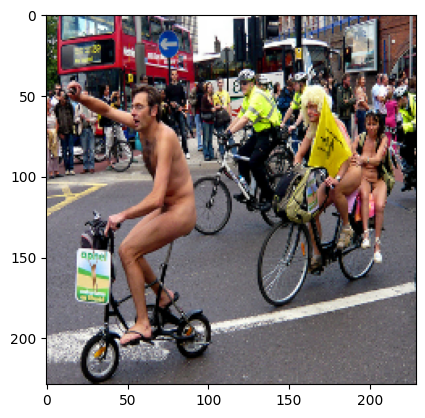

Predicted Caption: a man in a yellow shirt and blue shorts is riding a blue bike in a city


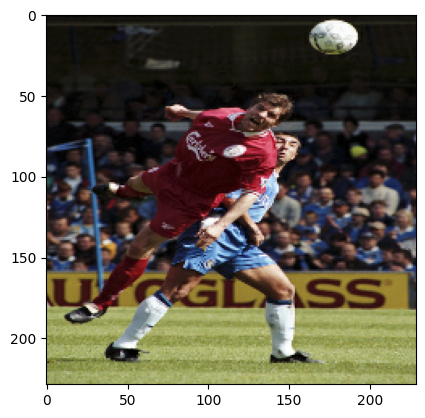

Predicted Caption: a man in a red uniform is playing a game


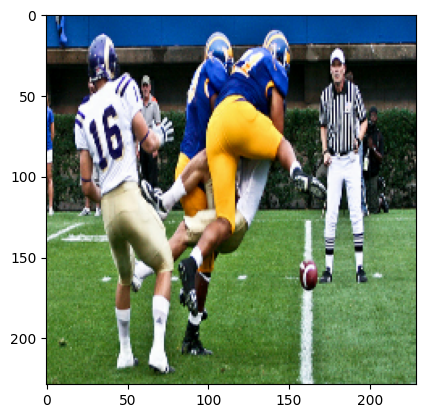

Predicted Caption: a group of men play soccer


In [94]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

def generate_caption_beam_search(beam_width=3):
    sample_img = np.random.choice(valid_images)
    sample_img = decode_and_resize(sample_img)

    img = sample_img.numpy().clip(0, 255).astype(np.uint8)
    plt.imshow(img)
    plt.show()

    img = tf.expand_dims(sample_img, 0)
    img = image_captioning_model.cnn_model(img)
    encoded_image = image_captioning_model.encoder(img, training=False)

    start_token = vectorization.get_vocabulary().index('<start>')
    end_token = vectorization.get_vocabulary().index('<end>')

    initial_state = tf.constant([[start_token]] * beam_width)
    initial_probs = tf.zeros((beam_width,))

    beams = [(initial_state[i], initial_probs[i]) for i in range(beam_width)]

    for _ in range(max_decoded_sentence_len):
        candidates = []
        for sequence, sequence_prob in beams:
            if sequence[-1] == end_token:
                candidates.append((sequence, sequence_prob))
                continue

            tokenized_caption = tf.expand_dims(sequence, 0)
            mask = tf.not_equal(tokenized_caption, 0)
            predictions = image_captioning_model.decoder(
                tokenized_caption, training=False, encoder_outputs=encoded_image, mask=mask
            )

            top_k_values, top_k_indices = tf.nn.top_k(predictions[0, -1, :], k=beam_width)

            for i in range(beam_width):
                token = top_k_indices[i].numpy()
                prob = top_k_values[i].numpy()
                new_sequence = tf.concat([sequence, [token]], axis=0)
                new_prob = sequence_prob - tf.math.log(prob)
                candidates.append((new_sequence, new_prob))

        ordered = sorted(candidates, key=lambda tup: tup[1])
        beams = ordered[:beam_width]

        if all(sequence[-1] == end_token for sequence, _ in beams):
            break

    best_sequence, _ = beams[0]
    decoded_caption = ' '.join([index_lookup[token.numpy()] for token in best_sequence[1:] if token != end_token])
    print('Predicted Caption:', decoded_caption)

# Generate captions using beam search
for _ in range(3):
    generate_caption_beam_search()

In [89]:
# drive_path = "/content/drive/MyDrive/tensorflow_course/image_caption_models/"

In [90]:
# image_captioning_model.save_weights(filepath=f'{drive_path}image_captioning_model_weights_ckpt_base1.weights.h5')

In [91]:
import numpy as np
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
# from nltk.translate.meteor_score import meteor_score
# from rouge import Rouge
import tensorflow as tf
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input

def calculate_bleu(reference, candidate):
    return sentence_bleu([reference.split()], candidate.split(), smoothing_function=SmoothingFunction().method1)

# def calculate_meteor(reference, candidate):
#     return meteor_score([reference.split()], candidate.split())

# def calculate_rouge(reference, candidate):
#     rouge = Rouge()
#     scores = rouge.get_scores(candidate, reference)
#     return scores[0]['rouge-l']['f']

class CIDErScore:
    def __init__(self, corpus):
        self.corpus = corpus
        self.document_frequency = {}
        self.compute_df()

    def compute_df(self):
        for caption in self.corpus:
            words = set(caption.split())
            for word in words:
                self.document_frequency[word] = self.document_frequency.get(word, 0) + 1

    def compute_cider(self, reference, candidate):
        ref_tfidf = self.compute_tfidf(reference)
        cand_tfidf = self.compute_tfidf(candidate)
        return np.dot(ref_tfidf, cand_tfidf) / (np.linalg.norm(ref_tfidf) * np.linalg.norm(cand_tfidf))

    def compute_tfidf(self, sentence):
        words = sentence.split()
        tf = {}
        for word in words:
            tf[word] = tf.get(word, 0) + 1
        
        tfidf = np.zeros(len(self.document_frequency))
        for i, word in enumerate(self.document_frequency):
            if word in tf:
                tfidf[i] = tf[word] * np.log(len(self.corpus) / self.document_frequency[word])
        return tfidf

def evaluate_captions(true_captions, generated_captions):
    bleu_scores = []
    meteor_scores = []
    rouge_scores = []
    cider_scorer = CIDErScore(true_captions + generated_captions)
    cider_scores = []

    for true, generated in zip(true_captions, generated_captions):
        bleu_scores.append(calculate_bleu(true, generated))
        meteor_scores.append(calculate_meteor(true, generated))
        rouge_scores.append(calculate_rouge(true, generated))
        cider_scores.append(cider_scorer.compute_cider(true, generated))

    return {
        "BLEU": np.mean(bleu_scores),
        "METEOR": np.mean(meteor_scores),
        "ROUGE-L": np.mean(rouge_scores),
        "CIDEr": np.mean(cider_scores)
    }

# Example usage:
# true_captions = ["A dog running in the park", "A cat sleeping on a couch"]
# generated_captions = ["A dog playing in the park", "A cat resting on a sofa"]
# scores = evaluate_captions(true_captions, generated_captions)
# print(scores)